# Solemne 3 y Recuperativa
### LSTM para Estacion Meteorologica

In [2]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv('data.csv')
df

,fecha,gas,temperatura,humedad,luminosidad,presion
0,1731686936454,592,28,47,485,94.76
1,1731686997476,765,28,46,529,94.76
2,1731687058489,695,28,46,508,94.76
3,1731687119511,535,28,46,510,94.77
4,1731687180982,528,28,46,510,94.76
...,...,...,...,...,...,...
8580,1732210539694,1040,28,39,923,95.04
8581,1732210600712,870,28,39,949,95.03
8582,1732210661721,971,28,39,910,95.04
8583,1732210722737,859,28,38,923,95.03


# Transformar fechas Unix a datetime

In [5]:
from datetime import datetime
lista_fechas = []
for i in df["fecha"]:
    timestamp = i / 1000
    date_time = datetime.fromtimestamp(timestamp)
    lista_fechas.append(date_time)


df["fecha_unix"] = df["fecha"]
df["fecha"] = lista_fechas

df

,fecha,gas,temperatura,humedad,luminosidad,presion,fecha_unix
0,2024-11-15 13:08:56.454,592,28,47,485,94.76,1731686936454
1,2024-11-15 13:09:57.476,765,28,46,529,94.76,1731686997476
2,2024-11-15 13:10:58.489,695,28,46,508,94.76,1731687058489
3,2024-11-15 13:11:59.511,535,28,46,510,94.77,1731687119511
4,2024-11-15 13:13:00.982,528,28,46,510,94.76,1731687180982
...,...,...,...,...,...,...,...
8580,2024-11-21 14:35:39.694,1040,28,39,923,95.04,1732210539694
8581,2024-11-21 14:36:40.712,870,28,39,949,95.03,1732210600712
8582,2024-11-21 14:37:41.721,971,28,39,910,95.04,1732210661721
8583,2024-11-21 14:38:42.737,859,28,38,923,95.03,1732210722737


In [6]:
#Revisar NULOS
df.isnull().sum()

fecha          0
gas            0
temperatura    0
humedad        0
luminosidad    0
presion        0
fecha_unix     0
dtype: int64

In [7]:
#Cantidad de datos
df.count()

fecha          8585
gas            8585
temperatura    8585
humedad        8585
luminosidad    8585
presion        8585
fecha_unix     8585
dtype: int64

In [8]:
df["presion"] #Presion atmosferica

#Transformar a series de tiempo

presion_series = pd.Series(df["presion"].values, index=df["fecha"])
presion_series

fecha
2024-11-15 13:08:56.454    94.76
2024-11-15 13:09:57.476    94.76
2024-11-15 13:10:58.489    94.76
2024-11-15 13:11:59.511    94.77
2024-11-15 13:13:00.982    94.76
                           ...  
2024-11-21 14:35:39.694    95.04
2024-11-21 14:36:40.712    95.03
2024-11-21 14:37:41.721    95.04
2024-11-21 14:38:42.737    95.03
2024-11-21 14:39:44.113    95.04
Length: 8585, dtype: float64

Tamaño set de entrenamiento: (5151,)
Tamaño set de validación: (1717,)
Tamaño set de prueba: (1717,)


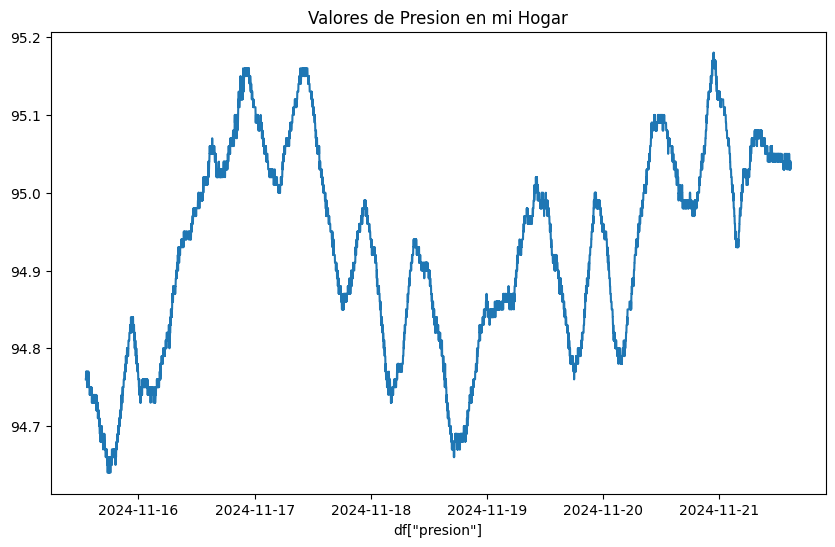

In [9]:
plt.figure(figsize=(10,6))
plt.plot(presion_series)
plt.xlabel("df[\"presion\"]")
plt.title("Valores de Presion en mi Hogar")
plt.show()

In [10]:
variable_objetivo = presion_series

In [11]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(serie, tr_size=0.6, vl_size=0.2, ts_size=0.2 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(variable_objetivo)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (5151,)
Tamaño set de validación: (1717,)
Tamaño set de prueba: (1717,)


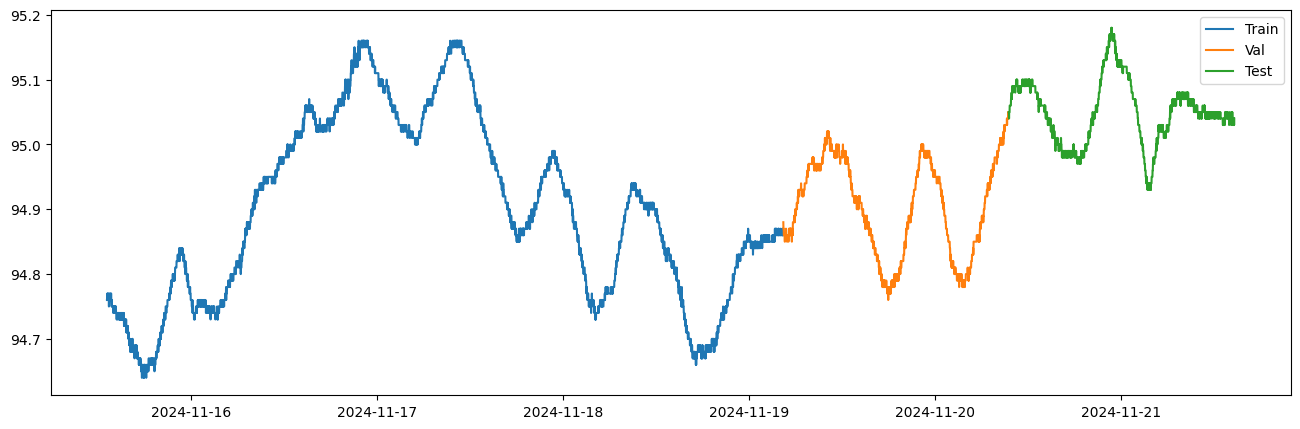

In [12]:
# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
plt.legend();

In [13]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [14]:
print("Tamaños Originales")
print(len(tr))
print(len(vl))
print(len(ts))

Tamaños Originales
5151
1717
1717


In [15]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 60    # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (5090, 60, 1), y_tr: (5090, 1, 1)
Set de validación - x_vl: (1656, 60, 1), y_vl: (1656, 1, 1)
Set de prueba - x_ts: (1656, 60, 1), y_ts: (1656, 1, 1)


In [16]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]


    # Generar listado con "scalers" (en este caso, por ser sólo 1 característica
    # se tendrá sólo 1 escalador)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tamaño nsamples x nfeatures
    # (en este caso 24x13)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [17]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento: 94.64/94.76/94.93
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-0.5384615384614904/0.11538461538464162

Min y_tr/y_vl/y_ts sin escalamiento: 94.64/94.76/94.93
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-0.5384615384614904/0.11538461538464162

Max x_tr/x_vl/x_ts sin escalamiento: 95.16/95.05/95.18
Max x_tr/x_vl/x_ts con escalamiento: 1.0/0.5769230769230944/1.0769230769230944

Max y_tr/y_vl/y_ts sin escalamiento: 95.16/95.05/95.18
Max y_tr/y_vl/y_ts con escalamiento: 1.0/0.5769230769230944/1.0769230769230944


In [18]:
x_tr_s.dtype

dtype('float64')

In [19]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 60 (minutos) x 1 (feature)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 40 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/40


c:\actions-runner\_work\_tool\Python\3.11.9\x64\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 3s - 126ms/step - loss: 0.6006 - val_loss: 0.2961
Epoch 2/40
20/20 - 2s - 79ms/step - loss: 0.5327 - val_loss: 0.2624
Epoch 3/40
20/20 - 1s - 75ms/step - loss: 0.4645 - val_loss: 0.2239
Epoch 4/40
20/20 - 1s - 71ms/step - loss: 0.3825 - val_loss: 0.1747
Epoch 5/40
20/20 - 1s - 71ms/step - loss: 0.2713 - val_loss: 0.1031
Epoch 6/40
20/20 - 1s - 71ms/step - loss: 0.1120 - val_loss: 0.0533
Epoch 7/40
20/20 - 1s - 72ms/step - loss: 0.0497 - val_loss: 0.0516
Epoch 8/40
20/20 - 1s - 73ms/step - loss: 0.0464 - val_loss: 0.0479
Epoch 9/40
20/20 - 1s - 74ms/step - loss: 0.0431 - val_loss: 0.0450
Epoch 10/40
20/20 - 1s - 71ms/step - loss: 0.0404 - val_loss: 0.0426
Epoch 11/40
20/20 - 1s - 72ms/step - loss: 0.0382 - val_loss: 0.0405
Epoch 12/40
20/20 - 1s - 72ms/step - loss: 0.0364 - val_loss: 0.0387
Epoch 13/40
20/20 - 1s - 72ms/step - loss: 0.0348 - val_loss: 0.0372
Epoch 14/40
20/20 - 1s - 74ms/step - loss: 0.0335 - val_loss: 0.0359
Epoch 15/40
20/20 - 1s - 71ms/step - loss: 0.0324 - v

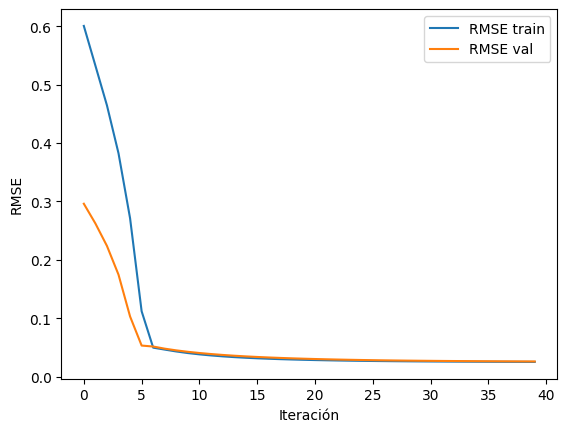

In [20]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend(); 

# 7. Desempeño del modelo

In [21]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.025
  RMSE val:	 0.026
  RMSE test:	 0.027


In [22]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [23]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)


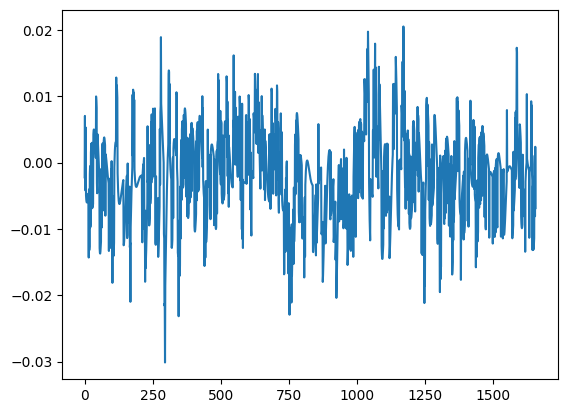

In [24]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [25]:
import datetime

start_date = vl.index[len(vl.index)-1]
curr_date = start_date


list_dates = []
series = []

for i in y_ts_pred:
    curr_date = curr_date + datetime.timedelta(minutes=1)
    list_dates.append(curr_date)


In [26]:
pred_series = pd.Series(data=y_ts_pred, index=list_dates)


# Grafico con predicciones de otro color

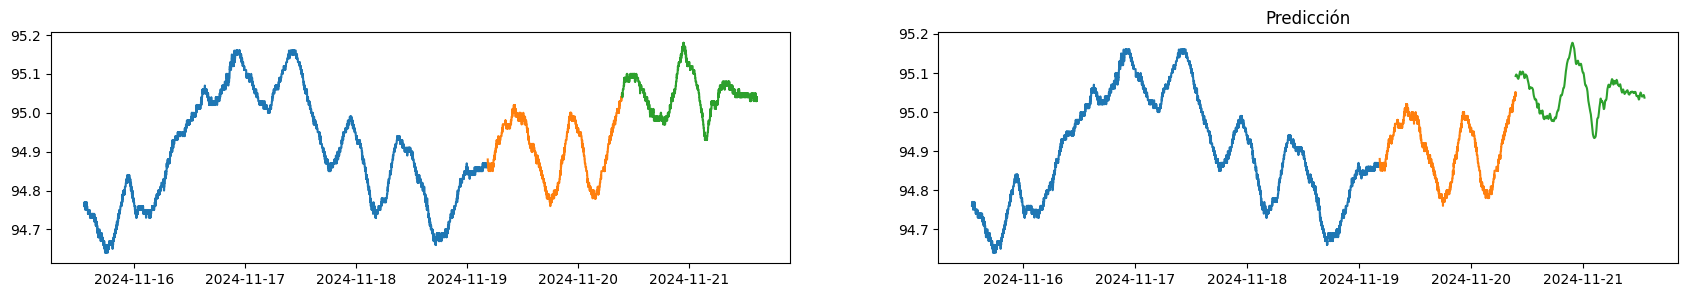

In [30]:
fig,axs = plt.subplots(1,2,figsize=(21,3))
axs[0].set_title("Valor Real")
axs[0].plot(tr)
axs[0].plot(vl)
axs[0].plot(ts)
axs[1].set_title("Predicción")
axs[1].plot(tr)
axs[1].plot(vl)
axs[1].plot(pred_series)

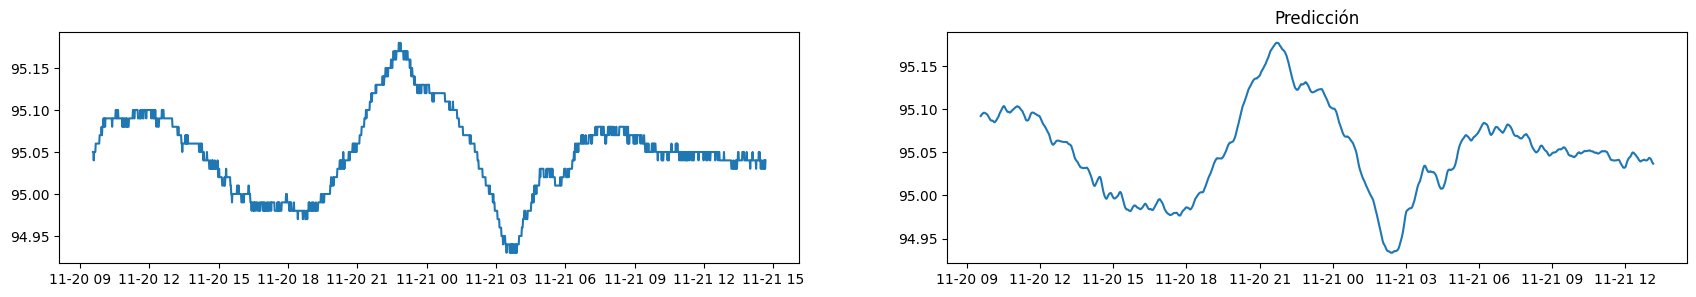

In [32]:
fig,axs = plt.subplots(1,2,figsize=(21,3))
axs[0].set_title("Valor Real")
axs[0].plot(ts)
axs[1].set_title("Predicción")
axs[1].plot(pred_series)